In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
import seaborn as sns

# Problem description

In this project, I'll be converting features which have gone through Principal Component Analysis to anonymize credit card usage data in order to detect fraudalent activity using supervised learning. I will be using several supervised machine learning algorithms, including Linear Regression, Decision Trees, SVM, and more alongside GridSearchCV to automatically find the best hyperparameters. The aim will be to find the most accurate algorithm with tweaked hyperparameters that is the most accurate. Given the unbalanced nature of this dataset, I am hoping to look into using SMOTE to try and balance the dataset and compare the results of not using SMOTE.


This is necessary for both the credit card companies and the customers as both have incentive to automatically identify fraud. This technology can help save money and even identify people using credit cards fraudulently. 

# Exploratory Data Analysis

In [2]:
#Import data
# The data can be found from this kaggle competition: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# View columns, rows and data types
print(data.info())

#View the first 5 rows of the data
print(data.head())

# View the stats of each column
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There are 284,807 rows of data all of which have data fully filled out so there is no null values to remove. Lets move on to looking at histograms of the columns to see if there are outliers that should be removed.

Our target column is going to be Class, which is 0 for a real charge and 1 for a fraudalent charge. This will be removed before training so the algorithms don't get access to it.

The Time and Amount columns will need to be standardized, but the other columns have such a small standard deviation that they shouldn't need it.

In [3]:
# View number of fraudulent transactions
print(data[data['Class'] == 1])

            Time        V1        V2        V3        V4        V5        V6  \
541        406.0 -2.312227  1.951992 -1.609851  3.997906 -0.522188 -1.426545   
623        472.0 -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823   
4920      4462.0 -2.303350  1.759247 -0.359745  2.330243 -0.821628 -0.075788   
6108      6986.0 -4.397974  1.358367 -2.592844  2.679787 -1.128131 -1.706536   
6329      7519.0  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746   
...          ...       ...       ...       ...       ...       ...       ...   
279863  169142.0 -1.927883  1.125653 -4.518331  1.749293 -1.566487 -2.010494   
280143  169347.0  1.378559  1.289381 -5.004247  1.411850  0.442581 -1.326536   
280149  169351.0 -0.676143  1.126366 -2.213700  0.468308 -1.120541 -0.003346   
281144  169966.0 -3.113832  0.585864 -5.399730  1.817092 -0.840618 -2.943548   
281674  170348.0  1.991976  0.158476 -2.583441  0.408670  1.151147 -0.096695   

              V7        V8        V9  .

The dataset is extremely unbalanced, there are just 492 rows of fraudulent transactions and 284,315 normal transactions. This will need to be addressed when evaluating the models. Regular accuracy would not be a good candidate and would be misleading.

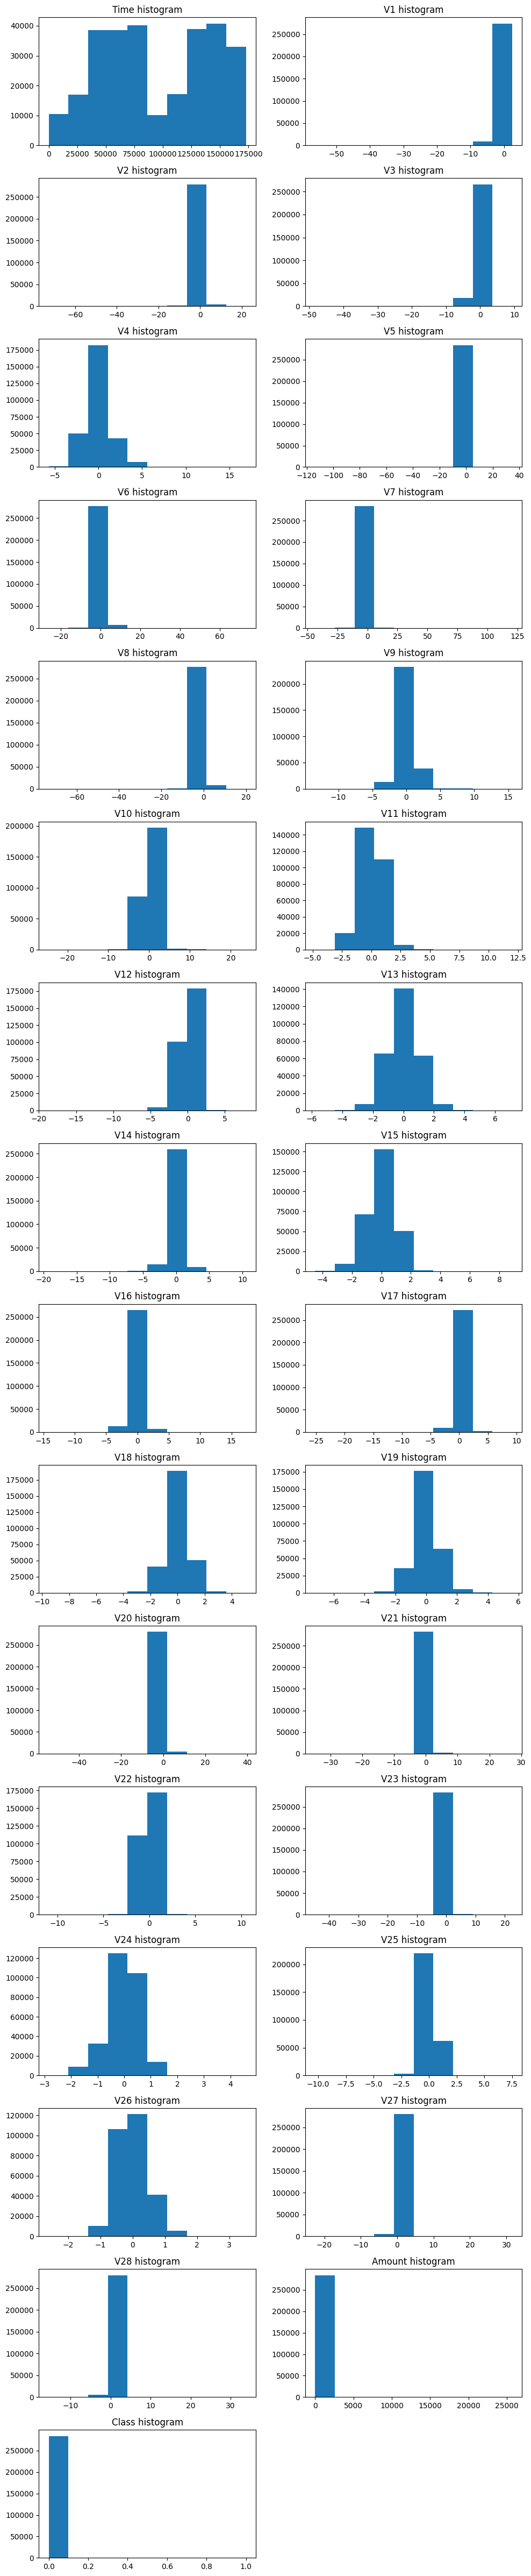

In [4]:
# View a histogram of each column
n_cols = 2
n_rows = int(np.ceil(len(data.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    axes[i].hist(data[column])
    axes[i].set_title(column + ' histogram')

if len(data.columns) % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In general outliers are few and far between in this dataset. Given just how rare fraudulent transactions are, it would be better to not remove outliers as those are likely examples of fraudulent transactions.

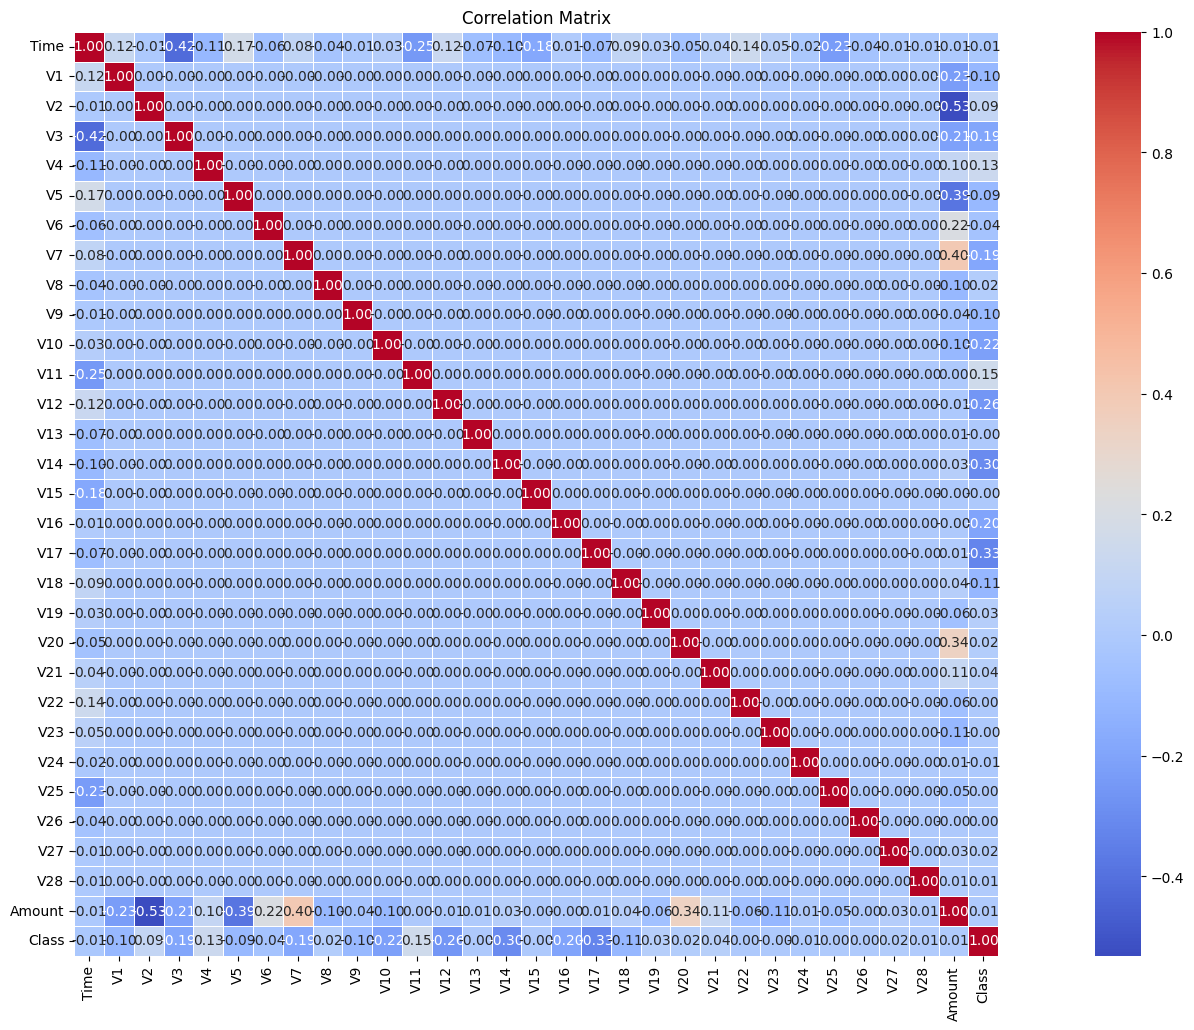

In [5]:
# Make a correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(25, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Given that V1-V28 are the PCA results this is a bit of an odder dataset to analyze since those features are more of a black box. We can see that the strongest correlations that occur with Class are V1, V3, V4, V7, V9, V10, V11, V12, V14, V16, and V17. Surprisingly the time and amount have next to no correlation. I'd expect at least the amount to have a higher correlation as a higher purchase price would seemingly be a strong predictor of a fraudulent charge. 

Since Amount and V2 have such a high correlation, and amount doesn't contribute much to the target, it could be dropped. That, along with only using the 11 PCA variables listed above could be further feature engineering steps.

# Analysis

In [6]:
print(data.tail())

# Lets standardize the Time and Amount columns
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

print(data.tail())

            Time         V1         V2        V3        V4        V5  \
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
284802 -2.606837 -4.918215  7.305334  1.914428  ...  0.213454  0.111864   
284803  1.058415  0.024330  0.294869  0.584800  ...  0.214205  0.924384   
284804  3.031260 -0.296827  0.708417  0.432454  ...  0.232045  0.578229   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.265245  0.800049   
284806 -0.649617  1.577006 -0.414650  0.486180  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28  Amount  \
284802  1.014480 -0.509348  1.436807  

In [7]:
# Remove class from the dataframe and save it to another variable
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=99) # Important to stratify the data given the imbalance

# Synthetic Minority Over-sampling Technique (SMOTE) will be used to assist in the class imbalance by creating synthetic examples of fraudulent charges
# More info here: https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c
smote = SMOTE(random_state=99)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Number of fraudulent charges without SMOTE: ' + str(len(y_train[y_train == 1])))
print('Number of fraudulent charges with SMOTE: ' + str(len(y_train[y_train_smote == 1])))

Number of fraudulent charges without SMOTE: 344
Number of fraudulent charges with SMOTE: 60043


In [8]:
# Helper function to minimize code repetition
def trainModel(model, parameters, model_name, X_train, y_train, X_test, y_test):
    scorers = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)
    }
    grid_search_cv = GridSearchCV(model, parameters, scoring=scorers, refit='recall', cv=3, n_jobs=6)
    grid_search_cv.fit(X_train, y_train)
        
    print(model_name + ' Results: ')
    print('Best Parameters:', grid_search_cv.best_params_)
    print('Best Recall Score:', grid_search_cv.best_score_)
    
    best_index = grid_search_cv.best_index_
    results = grid_search_cv.cv_results_
    print("\nScores for the best parameters:")
    for scorer in scorers:
        mean_score = results['mean_test_' + scorer][best_index]
        std_score = results['std_test_' + scorer][best_index]
        print(f"{scorer.capitalize()} - Mean: {mean_score:.4f}, Std: {std_score:.4f}")
    
    best_model = grid_search_cv.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1] if 'roc_auc' in scorers else None
    
    print("\nScores on the Test Data:")
    test_scores = {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    for metric, score in test_scores.items():
        if score is not None:
            print(f"{metric.capitalize()}: {score:.4f}")

    if y_pred_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        auprc = auc(recall, precision)
        print(f"AUPRC: {auprc:.4f}")
            
    print()
    return grid_search_cv

In [9]:
# Train SMOTE models
log_reg_model = LogisticRegression(random_state=99)
log_reg_grid_search_smote = trainModel(log_reg_model, {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}, 'LogisticRegression', X_train_smote, y_train_smote, X_test, y_test)

dt_model = DecisionTreeClassifier(random_state=99)
dt_grid_search_smote = trainModel(dt_model, {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}, 'DecisionTreeClassifier', X_train_smote, y_train_smote, X_test, y_test)

gaussian_nb_model = GaussianNB()
gaussian_nb_grid_search_smote = trainModel(gaussian_nb_model, {}, 'GaussianNB', X_train_smote, y_train_smote, X_test, y_test)

sgd_model = SGDClassifier(penalty='l2', random_state=99)
sgd_grid_search_smote = trainModel(sgd_model, {
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['log_loss'],
    'max_iter': [1000, 2000]
}, 'SGDClassifier', X_train_smote, y_train_smote, X_test, y_test)

LogisticRegression Results: 
Best Parameters: {'C': 10, 'solver': 'newton-cg'}
Best Recall Score: 0.9144859813084113

Scores for the best parameters:
Precision - Mean: 0.9702, Std: 0.0004
Recall - Mean: 0.9145, Std: 0.0011
F1_score - Mean: 0.9415, Std: 0.0007
Roc_auc - Mean: 0.9884, Std: 0.0003

Scores on the Test Data:
Precision: 0.0544
Recall: 0.9459
F1_score: 0.1029
Roc_auc: 0.9864
AUPRC: 0.7669

DecisionTreeClassifier Results: 
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
Best Recall Score: 0.9945432619837202

Scores for the best parameters:
Precision - Mean: 0.9748, Std: 0.0009
Recall - Mean: 0.9945, Std: 0.0010
F1_score - Mean: 0.9846, Std: 0.0008
Roc_auc - Mean: 0.9982, Std: 0.0002

Scores on the Test Data:
Precision: 0.0523
Recall: 0.8784
F1_score: 0.0987
Roc_auc: 0.9383
AUPRC: 0.6867

GaussianNB Results: 
Best Parameters: {}
Best Recall Score: 0.835413526278766

Scores for the best parameters:
Precision - Mean: 0.9708, Std: 0.0000
Recall -

In [10]:
# Train non-SMOTE models
log_reg_model = LogisticRegression(random_state=99)
log_reg_grid_search = trainModel(log_reg_model, {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}, 'LogisticRegression', X_train, y_train, X_test, y_test)

dt_model = DecisionTreeClassifier(random_state=99)
dt_grid_search = trainModel(dt_model, {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}, 'DecisionTreeClassifier', X_train, y_train, X_test, y_test)

gaussian_nb_model = GaussianNB()
gaussian_nb_grid_search = trainModel(gaussian_nb_model, {}, 'GaussianNB', X_train, y_train, X_test, y_test)

sgd_model = SGDClassifier(penalty='l2', random_state=99)
sgd_grid_search = trainModel(sgd_model, {
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['log_loss'],
    'max_iter': [1000, 2000]
}, 'SGDClassifier', X_train, y_train, X_test, y_test)

LogisticRegression Results: 
Best Parameters: {'C': 10, 'solver': 'newton-cg'}
Best Recall Score: 0.6248410882278159

Scores for the best parameters:
Precision - Mean: 0.8858, Std: 0.0118
Recall - Mean: 0.6248, Std: 0.0525
F1_score - Mean: 0.7312, Std: 0.0320
Roc_auc - Mean: 0.9689, Std: 0.0079

Scores on the Test Data:
Precision: 0.8661
Recall: 0.6554
F1_score: 0.7462
Roc_auc: 0.9844
AUPRC: 0.7683

DecisionTreeClassifier Results: 
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best Recall Score: 0.761632341723875

Scores for the best parameters:
Precision - Mean: 0.8563, Std: 0.0493
Recall - Mean: 0.7616, Std: 0.0037
F1_score - Mean: 0.8054, Std: 0.0193
Roc_auc - Mean: 0.9034, Std: 0.0201

Scores on the Test Data:
Precision: 0.8871
Recall: 0.7432
F1_score: 0.8088
Roc_auc: 0.9531
AUPRC: 0.7592

GaussianNB Results: 
Best Parameters: {}
Best Recall Score: 0.8255275870836511

Scores for the best parameters:
Precision - Mean: 0.0600, Std: 0.0016
Recall - 

# Result

This works pretty well! But, lets do one final test of feature engineering that uses only V1, V3, V4, V7, V9, V10, V11, V12, V14, V16, and V17. This would likely increase LogisticRegression performance and allow more computationally intensive algorithms (KNN) to be trained since there are less features.

In [11]:
# Select specific columns
X = data[['V1', 'V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']]
y = data['Class']

X_train_engineered, X_test_engineered, y_train_engineered, y_test_engineered = train_test_split(X, y, test_size=0.3, stratify=y, random_state=99) # Important to stratify the data given the imbalance

# Train engineered models
log_reg_model = LogisticRegression(random_state=99)
log_reg_grid_search_engineered = trainModel(log_reg_model, {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}, 'LogisticRegression', X_train_engineered, y_train_engineered, X_test_engineered, y_test_engineered)

dt_model = DecisionTreeClassifier(random_state=99)
dt_grid_search_engineered = trainModel(dt_model, {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}, 'DecisionTreeClassifier', X_train_engineered, y_train_engineered, X_test_engineered, y_test_engineered)

gaussian_nb_model = GaussianNB()
gaussian_nb_grid_search_engineered = trainModel(gaussian_nb_model, {}, 'GaussianNB', X_train_engineered, y_train_engineered, X_test_engineered, y_test_engineered)

sgd_model = SGDClassifier(penalty='l2', random_state=99)
sgd_grid_search_engineered = trainModel(sgd_model, {
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['log_loss'],
    'max_iter': [1000, 2000]
}, 'SGDClassifier', X_train_engineered, y_train_engineered, X_test_engineered, y_test_engineered)

knn_model = KNeighborsClassifier()
knn_grid_search_engineered = trainModel(knn_model, {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}, 'KNN', X_train_engineered, y_train_engineered, X_test_engineered, y_test_engineered)

LogisticRegression Results: 
Best Parameters: {'C': 1, 'solver': 'newton-cg'}
Best Recall Score: 0.6161454360539028

Scores for the best parameters:
Precision - Mean: 0.8916, Std: 0.0108
Recall - Mean: 0.6161, Std: 0.0564
F1_score - Mean: 0.7270, Std: 0.0356
Roc_auc - Mean: 0.9710, Std: 0.0043

Scores on the Test Data:
Precision: 0.8679
Recall: 0.6216
F1_score: 0.7244
Roc_auc: 0.9830
AUPRC: 0.7668

DecisionTreeClassifier Results: 
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best Recall Score: 0.7645308924485126

Scores for the best parameters:
Precision - Mean: 0.8498, Std: 0.0282
Recall - Mean: 0.7645, Std: 0.0142
F1_score - Mean: 0.8044, Std: 0.0050
Roc_auc - Mean: 0.9187, Std: 0.0065

Scores on the Test Data:
Precision: 0.8923
Recall: 0.7838
F1_score: 0.8345
Roc_auc: 0.9257
AUPRC: 0.7456

GaussianNB Results: 
Best Parameters: {}
Best Recall Score: 0.8372489193999492

Scores for the best parameters:
Precision - Mean: 0.1165, Std: 0.0032
Recall - 

<Figure size 1000x800 with 0 Axes>

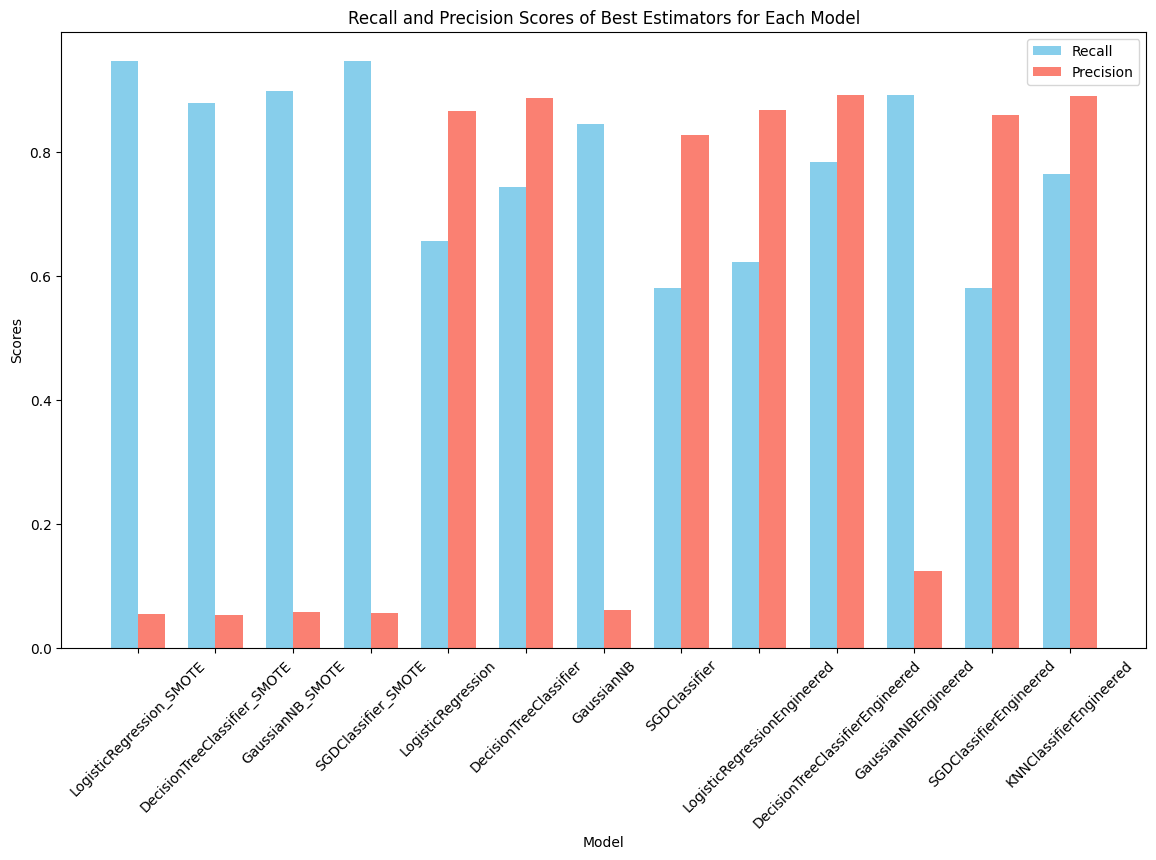

In [12]:
grid_search_objects = [
    ('LogisticRegression_SMOTE', log_reg_grid_search_smote),
    ('DecisionTreeClassifier_SMOTE', dt_grid_search_smote),
    ('GaussianNB_SMOTE', gaussian_nb_grid_search_smote),
    ('SGDClassifier_SMOTE', sgd_grid_search_smote),
    ('LogisticRegression', log_reg_grid_search),
    ('DecisionTreeClassifier', dt_grid_search),
    ('GaussianNB', gaussian_nb_grid_search),
    ('SGDClassifier', sgd_grid_search),
    ('LogisticRegressionEngineered', log_reg_grid_search_engineered),
    ('DecisionTreeClassifierEngineered', dt_grid_search_engineered),
    ('GaussianNBEngineered', gaussian_nb_grid_search_engineered),
    ('SGDClassifierEngineered', sgd_grid_search_engineered),
    ('KNNClassifierEngineered', knn_grid_search_engineered)
]

plt.figure(figsize=(10, 8))

model_names = []
recall_scores = []
precision_scores = []

for name, grid_search in grid_search_objects:
    # Determine the correct test dataset based on the model's feature set
    if 'Engineered' in name:
        X_test_current = X_test_engineered
    else:
        X_test_current = X_test

    # Get the best estimator and make predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_current)

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    model_names.append(name)
    recall_scores.append(recall)
    precision_scores.append(precision)

# Chart out the precision and recall scores of all the models
x = np.arange(len(model_names))
width = 0.35
fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, recall_scores, width, label='Recall', color='skyblue')
rects2 = ax.bar(x + width/2, precision_scores, width, label='Precision', color='salmon')
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Recall and Precision Scores of Best Estimators for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
plt.show()

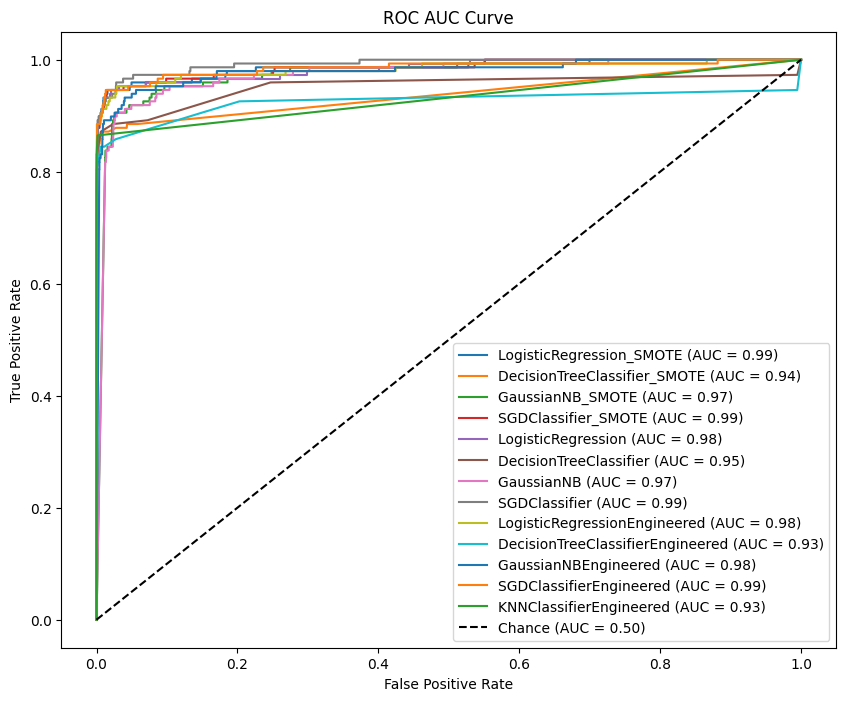

In [13]:
plt.figure(figsize=(10, 8))

for name, grid_search in grid_search_objects:
    
    if 'Engineered' in name:
        X_test_current = X_test_engineered
    else:
        X_test_current = X_test

    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_current)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# ROC AUC Plot
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()

In the graphs above, we can take away a few conclusions:
* There appears to be a tradeoff between a model's recall and precision
* The SMOTE models have the best recall out of all the models, but also the worst precision scores
* The most well balanced models in terms of recall and precision are generally the non-SMOTE, non-feature-engineered models (excluding GaussianNB). The engineered KNN and Decision Tree models also perform well.
* The engineered models overall perform about the same as their non-engineered, non-SMOTE counterparts. There does seem to be slight gains in recall with the engineered models though.
* Overall, the most well balanced models are the engineered DecisionTreeClassifier and KNNClassifier. The best recall models are Logistic Regression w/ SMOTE and SGD Classifier w/ SMOTE.

AUC is not a significant metric as most of the models scored .98 and above. The engineered DTC and KNN models performed the worst here which is interesting. 


The final test here is to try combining some of the differing models in a VotingClassifier to create a model that has both high precision and recall.

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

log_reg_smote = log_reg_grid_search_smote.best_estimator_
dt_classifier = dt_grid_search.best_estimator_
sgd_engineered = sgd_grid_search_engineered.best_estimator_

# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr_smote', log_reg_smote),
        ('dt', dt_classifier),
        ('sgd_eng', sgd_engineered)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred_voting))

precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)

print(f'Precision (Voting): {precision_voting:.2f}')
print(f'Recall (Voting): {recall_voting:.2f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.63      0.73       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Precision (Voting): 0.86
Recall (Voting): 0.63


These results are unremarkable. There may be a better combination or weight on the models to improve the results.

# Conclusion

Given that recall seems to be the most important metric (it's more important to catch fraudulent charges than to miss them, even if you end up with false positives), LogisticRegression and SGD work well for that use case. However, since their precision is so low, in a coorporate setting it would likely be ideal to use a combination of models in a voting classifier or some other way to create a high precision and recall model. Obviously the voting classifier above did not meet expectations, but there are other combos that may work.

I was pleasantly surprised to see how well SMOTE worked to improve recall overall. It's surprising that it creates a terrible precision score though. The synthetic data leads to the models identifying more false positives. Looking into adjusting the synthetic data may help improve the precision of these models.